In [8]:
from game_of_life import Game_of_life
from models.autoencoder import ConvolutionalAutoencoder
from models.fullycon import CullyConnCoder
from matplotlib import pyplot as plt

import torch.nn as nn
import torch
import tqdm
import numpy as np
import torch.optim as optim

%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"

SIZE=16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
mask = torch.ones((1, SIZE, SIZE)).to(device)

In [10]:
from deepq_utils import ReplayMemory, Transition

def optimize_model(policy_net: torch.nn.Module, target_net: torch.nn.Module, memory: ReplayMemory, optimizer: torch.optim.Optimizer, BATCH_SIZE: int, GAMMA: int, mask:torch.tensor):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    # print(state_batch.shape)
    # print(action_batch.shape)
    # print(reward_batch.shape)
    # print(next_state_batch.shape)


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = torch.amax(policy_net.place(state_batch, mask) * action_batch, dim=(1,2,3))
    # print(state_action_values.shape)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.amax(target_net.place(next_state_batch, mask), dim=(1,2,3)).to(device)
        # print(next_state_values.shape)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # print(reward_batch.shape)
    # print(next_state_values.shape)
    # print(expected_state_action_values.shape)

    # Compute Huber loss
    criterion = nn.HuberLoss()
    # criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimizer.step()

In [11]:
from plotting import plot_state

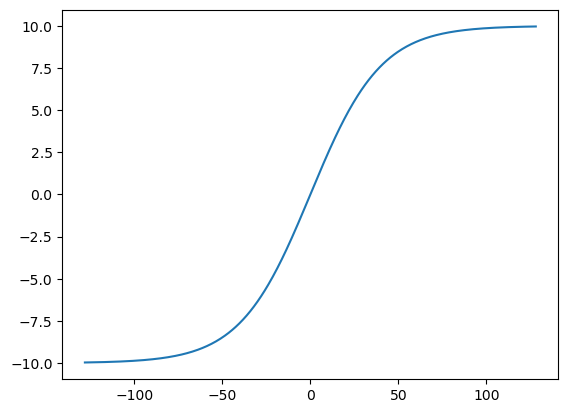

In [12]:
reward_samples = np.linspace(-128, 128, 500)
out = torch.nn.functional.sigmoid(torch.from_numpy(reward_samples)/20).numpy()*20-10
plt.plot(reward_samples, out)
plt.show()

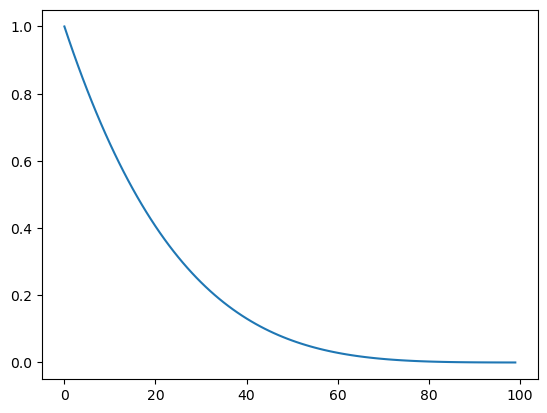

In [13]:
def generate_eps(num_episodes:int)->np.ndarray:
  return np.power(np.linspace(1.0, 0.1, num_episodes), 4.5)

data = generate_eps(100)
plt.plot(data)
plt.show()

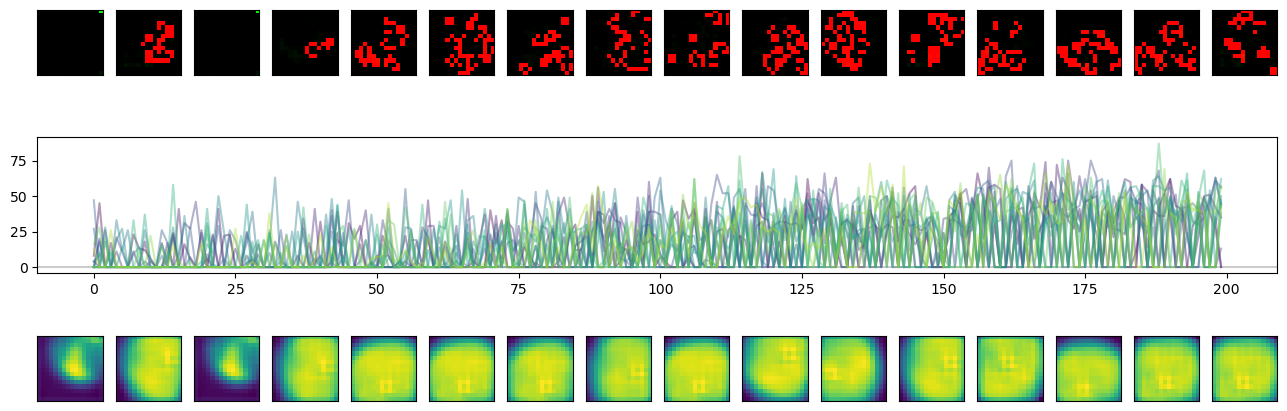

100%|██████████| 200/200 [08:01<00:00,  2.41s/it]


In [15]:
import math
# from models.simpLEnet import SimLEnet
from models.resnet import KaoResnet
from deepq_utils import GameEnv, select_action
from tqdm import tqdm

BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 100
GAMMA = 0.92
TAU = 0.15
LR = 4e-4
num_episodes = 200
EPS = generate_eps(num_episodes)
NUM_MOVES = 1
STEPS = 100

policy_net = KaoResnet(SIZE).to(device)
target_net = KaoResnet(SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)

rewards = []
validation_rewards = []

for i_episode in tqdm(range(num_episodes)):
    env = GameEnv(size=SIZE, batch_size=BATCH_SIZE, mask=mask)
    # Initialize the environment and get its state
    actions  = torch.zeros_like(env.state, dtype=torch.float) # visualization only
    state = env.state

    if( i_episode % 50 == 0):
        # print("VALIDATION")
        eps = 0
        validation_rewards.append([])
    else:
        eps = EPS[i_episode]

    for t in range(STEPS):
        for i in range(NUM_MOVES):
            action = select_action(state, eps, policy_net, mask)
            actions += action.float()
            next_state, reward = env.step(action)
            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            # Move to the next state
            state = next_state
            if i_episode % 5 == 0:
                validation_rewards[-1].append(reward.cpu().numpy())
    
        # Perform one step of the optimization (on the policy network)
        optimize_model(
            policy_net=policy_net,
            target_net=target_net,
            memory=memory,
            optimizer=optimizer,
            BATCH_SIZE=TRAIN_BATCH_SIZE,
            GAMMA=GAMMA,
            mask=mask
        )

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
    
    with torch.no_grad():
        target_model_preds = target_net.place(action, mask).cpu().numpy()
        policy_model_preds = policy_net.place(action, mask).cpu().numpy()
        # print(target_model_preds[0])
    
    env.reset()
    rw = reward.sum(dim=(1)).cpu().numpy()
    rewards.append(reward.sum(dim=(1)).cpu().numpy())
    # print(i_episode, eps, rw)
    plot_state(state, actions, rewards, None, policy_model_preds)

In [ ]:
torch.save(policy_net.state_dict(), f"./checkpoints/policy-{NUM_MOVES}mov-{SIZE}x{SIZE}-{num_episodes}epi.pth")

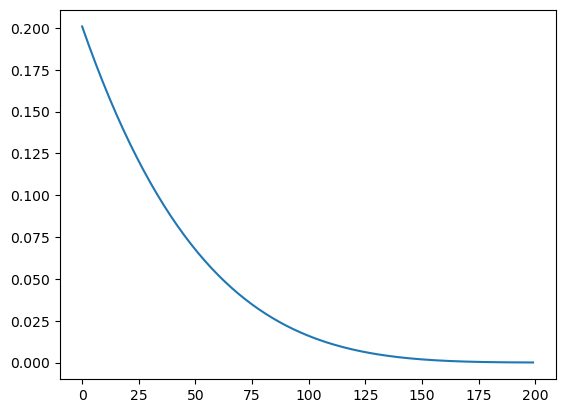

In [16]:
def generate_eps2(num_episodes:int)->np.ndarray:
    return np.power(np.linspace(0.7, 0.1, num_episodes), 4.5)

data = generate_eps2(200)
fig, ax = plt.subplots()
ax.plot(data)
display(fig)

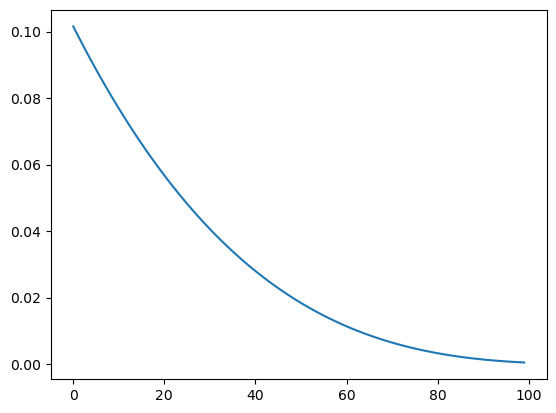

In [30]:
def generate_eps3(num_episodes:int)->np.ndarray:
    return np.power(np.linspace(0.5, 0.1, num_episodes), 3.3)

data = generate_eps3(100)
fig, ax = plt.subplots()
ax.plot(data)
display(fig)

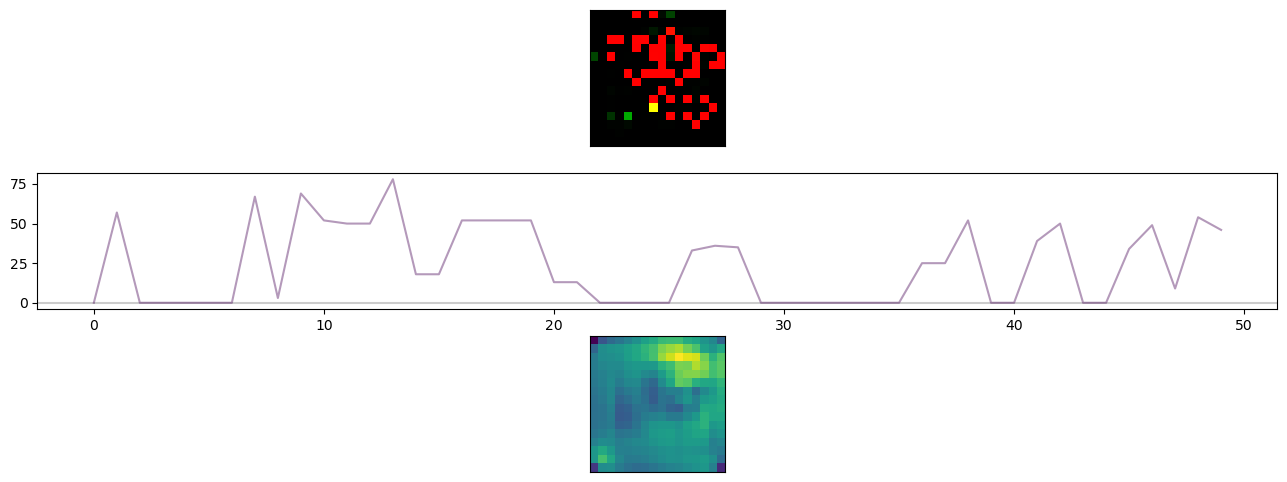

Training: 100%|█████████████████████████████████████████| 50/50 [06:30<00:00,  7.81s/it, Go to=1000]


In [31]:
BATCH_SIZE = 1
TRAIN_BATCH_SIZE = 10
GAMMA = 0.9
TAU = 0.15
LR = 7e-5
num_episodes = 50
EPS = generate_eps3(num_episodes)
NUM_MOVES = 1
STEPS = 1000

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)

rewards = []
validation_rewards = []
got_to = STEPS

with tqdm(total=num_episodes, desc="Training", ncols=100) as pbar:
    for i_episode in range(num_episodes):
        env = GameEnv(size=SIZE, batch_size=BATCH_SIZE, mask=mask)
        # Initialize the environment and get its state
        actions  = torch.zeros_like(env.state, dtype=torch.float) # visualization only
        state = env.state
        # if( i_episode % 10 == 0):
        #     # print("VALIDATION")
        #     eps = 0
        #     validation_rewards.append([])
        # else:
        eps = EPS[i_episode]
            
        for t in range(STEPS):
            # for i in range(NUM_MOVES):
            # print(env.reward())
            if torch.sum(env.reward()) == 0:
                got_to = t
                break
            action = select_action(state, eps, policy_net, mask)
            actions += action.float()
            next_state, reward = env.step(action)
            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            # Move to the next state
            state = next_state
            # if i_episode % 5 == 0:
            #     validation_rewards[-1].append(reward.cpu().numpy())
        
            # Perform one step of the optimization (on the policy network)
            optimize_model(
                policy_net=policy_net,
                target_net=target_net,
                memory=memory,
                optimizer=optimizer,
                BATCH_SIZE=TRAIN_BATCH_SIZE,
                GAMMA=GAMMA,
                mask=mask
            )
    
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
        
        with torch.no_grad():
            target_model_preds = target_net.place(action, mask).cpu().numpy()
            policy_model_preds = policy_net.place(action, mask).cpu().numpy()
            # print(target_model_preds[0])
        
        env.reset()
        rw = reward.sum(dim=(1)).cpu().numpy()
        rewards.append(reward.sum(dim=(1)).cpu().numpy())
        # print(i_episode, eps, rw)
        plot_state(state, actions, rewards, None, policy_model_preds)
        pbar.set_postfix({"Go to": got_to})
        pbar.update(1)
        got_to = STEPS

In [58]:
torch.save(policy_net.state_dict(), f"./checkpoints/policy-final.pth")

In [59]:
def generate_batch1(batch_size, size, sims=5):
    with torch.no_grad():
        game = Game_of_life(size)
        # game.cuda()
        # random binary noise of size size x size
        # prev_batch = torch.randint(0, 2, (batch_size, 1, size, size))
        prev_batch = (torch.rand((batch_size, 1, size, size)) > 0.9).int()
        # prev_batch.cuda()
        batch = game(prev_batch)
        for i in range(sims):
            batch, prev_batch = game(batch), batch

        # return torch.nn.functional.one_hot(prev_batch.long(), 2).float(), torch.nn.functional.one_hot(batch.long(), 2).float()
        
        return batch

test_state = generate_batch1(1, SIZE, sims=0).to(device)

In [92]:
import matplotlib.animation as animation


# Set up the figure, the axis, and the plot
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
frames = []

env = GameEnv(size=SIZE, batch_size=1, mask=mask)
env.state = test_state
# Create the frames
for _ in range(1000):
    im = ax.imshow(env.state.squeeze().squeeze().cpu().numpy(), animated=True)
    frames.append([im])
    env.step(torch.zeros_like(env.state))
    # if torch.sum(env.reward()) == 0:
    #     break
    

# Create an ArtistAnimation
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)

ani.save('without.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [96]:
import matplotlib.animation as animation

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        action = select_action(state, eps, policy_net, mask)
        next_state, reward = env.step(action)

# Set up the figure, the axis, and the plot
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
frames = []

env = GameEnv(size=SIZE, batch_size=1, mask=mask)
env.state = test_state
# Create the frames
for _ in range(1000):
    action = select_action(env.state, 0, policy_net, mask)
    # im = ax.imshow(((env.state + action) % 2).squeeze().squeeze().cpu().numpy(), animated=True)
    im = ax.imshow(
            torch.cat((env.state, action, torch.zeros_like(action)), dim=1)
                .squeeze().permute(1, 2, 0).cpu().numpy()*255,
            animated=True)
    # print(torch.cat((env.state, action, torch.zeros_like(action)), dim=1)
    #             .squeeze().permute(1, 2, 0).cpu().numpy()[:,:,0])
    # break
    frames.append([im])
    _, reward = env.step(action)
    # if torch.sum(reward) == 0:
    #     break
    

# Create an ArtistAnimation
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)

ani.save('with.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [97]:
# Set up the figure, the axis, and the plot
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
frames = []

env = GameEnv(size=SIZE, batch_size=1, mask=mask)
env.state = test_state
# Create the frames
for _ in range(1000):
    action = torch.zeros_like(env.state)
    action[0, 0, torch.randint(0, 16, (1,)).item(), torch.randint(0, 16, (1,)).item()] = 1
    # print(torch.cat((env.state, action, torch.zeros_like(action)), dim=1).squeeze().permute(1, 2, 0).shape)
    im = ax.imshow(
            torch.cat((env.state, action, torch.zeros_like(action)), dim=1)
                .squeeze().permute(1, 2, 0).cpu().numpy()*255, animated=True)
    frames.append([im])
    _, reward = env.step(action)
    # if torch.sum(reward) == 0:
    #     break
    

# Create an ArtistAnimation
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)

ani.save('random.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


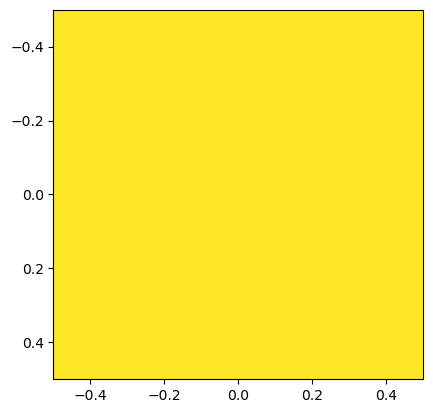

(0.267004, 0.004874, 0.329415, 1.0)

In [116]:
from matplotlib import colormaps
plt.imshow(np.array(colormaps["viridis"](255))[np.newaxis, np.newaxis, :])
plt.show()
colormaps["viridis"](0)

In [94]:
validation_rewards = np.array(validation_rewards).squeeze()

In [96]:
validation_rewards.shape

(4, 5000, 4)

In [95]:
import matplotlib as mpl
fig = plt.figure(figsize=(14, 7))
fig.suptitle("Rewards on validation runs")

gs = fig.add_gridspec(2, 4)

for i, val in enumerate([0, 1, 2, 3]):
    ax = fig.add_subplot(gs[0, i])
    ax.set_ylim(0, 160)
    for j in range(6):    
        ax.plot(validation_rewards[val, :, j], label=f"Validation {i}", alpha=0.7)
    # ax.legend()
    
colors = mpl.colormaps['plasma'](np.linspace(0, 1, 15))
ax = fig.add_subplot(gs[1, :])
ax.set_ylim(0, 130)
for i in range(4):
    ax.plot(validation_rewards.mean(axis=2)[i], alpha=0.7, color=colors[i])
    ax.set_title("Mean reward over all validation runs")
display(fig)

IndexError: index 4 is out of bounds for axis 2 with size 4

In [ ]:
import pygame
from deepq_utils import generate_batch
SIZE = 32
GAME_SIZE = 10
WAIT = 20

calc_wait = round( WAIT / SIZE**0.5 ) 

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        action = select_action(state, eps, policy_net, mask)
        next_state, reward = env.step(action)

def display_grid(grid, screen):
    size = len(grid)
    cell_size = GAME_SIZE
    for i in range(size):
        for j in range(size):
            if grid[i][j] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (i*cell_size, j*cell_size, cell_size, cell_size))
            else:
                pygame.draw.rect(screen, (0, 0, 0), (i*cell_size, j*cell_size, cell_size, cell_size))
    pygame.display.flip()

env = GameEnv(size=SIZE, batch_size=1, mask=mask)
pygame.init()
screen = pygame.display.set_mode((SIZE*GAME_SIZE, SIZE*GAME_SIZE))

running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                running = False
        # r resetes game with new random grid
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:
                env.reset()
        # plt.imshow(grid) and save it when S is pressed
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                plt.imshow(env.state.squeeze().squeeze().cpu().numpy(), cmap='gray')
                plt.savefig(f"batched_{i}.png")
    env.step(select_action(env.state, 0, policy_net, mask))
    display_grid(env.state.squeeze().squeeze().cpu().numpy(), screen)
    pygame.time.wait(calc_wait)
    # if(tensor.sum() == 0 or tensor.sum() == SIZE*SIZE):
    #     running = False
    i += 1

pygame.quit()